Author: Katie Fasbender (katiefasbender@montana.edu)

This is a supplemetal file to the work "Exploring the Solar System with the NOIRLab Source Catalog: I. Detecting Objects with CANFind" by Katie M. Fasbender \& David L. Nidever.

The following code generates figures of the results from CANFind's run on NSC DR1.  CANFind detected 500,000 tracklets, each of which have the following recorded information:

Per tracklet:

- Mean tracklet RA, Dec [$^{\circ}$] 
- Tracklet observation time [Modified Julian Date (mjd)]
- Tracklet proper motion in equatorial coordinates $\mu_{RA}$, $\mu_{Dec}$ ['' hr$^{-1}$]
- Tracklet proper motion in geocentric ecliptic coordinates $\mu_{lon}$, $\mu_{lat}$ ['' hr$^{-1}$]
- \# measurements N$_{meas}$
- Unique tracklet label
- Unique track label
- HEALPix (NSIDE=128)
- Mean tracklet magnitude (mag_auto) [mag]
- Filter Flags (u,g,r,i,z,Y,VR)

Tracklet information is recorded in the file ""

A full list of the HEALPix searched is recorded in the file ""

Both files, as well as this one, are available at github link here.

In [83]:
#--------------------------------------
# Imports
#--------------------------------------

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import healpy as hp

from astropy.io import fits
from astropy.table import Table 
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import get_sun
from astropy.time import Time

from matplotlib import pyplot as plt
from matplotlib.projections.geo import GeoAxes
from matplotlib import cm, colors

In [208]:
#--------------------------------------
# Functions
#--------------------------------------

def cbar(mappable,title=" ",titsize=10,marksize=10,titcol="k",lpad=35,titrot=270,markrot=0,ori="vertical",ticklab="yticklabels",loc="right",bpad=0.05,xx=0,caxx=[]):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax) 
    if caxx:
        cax=fig.add_axes(caxx) 
    else:
        cax=divider.append_axes(position=loc, size="5%", pad=bpad)
    cbar = fig.colorbar(mappable, cax=cax,orientation=ori)
    cbar.set_label(title,size=titsize,color=titcol,labelpad=lpad,rotation=titrot,x=xx)
    plt.setp(plt.getp(cbar.ax.axes, ticklab),color=titcol,fontsize=marksize,rotation=markrot)
    plt.sca(last_axes)
    return cbar

def hp_cbar(title=" ",titsize=10,marksize=10,titcol="k",lpad=35,titrot=270,markrot=0,ori="vertical",ticklab="yticklabels",loc="right",bpad=0.05):
    #https://github.com/zonca/paperplots/blob/master/python/scripts/PlanckFig_map.py
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    #figur = plt.gcf()
    last_axes = plt.gca()
    image = last_axes.get_images()[0]
    ax=image.axes
    figur = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(position=loc, size="50%", pad=bpad)
    cbar = figur.colorbar(image, cax=cax,orientation=ori)
    cbar.set_label(title,size=titsize,color=titcol,labelpad=lpad,rotation=titrot)
    plt.setp(plt.getp(cbar.ax.axes, ticklab),color=titcol,fontsize=marksize,rotation=markrot)
    plt.sca(last_axes)
    return cbar

class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
    """Shifts labelling by pi
    Shifts labelling from -180,180 to 0-360"""
    def __call__(self, x, pos=None):
        if x != 0:
            x *= -1
        if x < 0:
            x += 2*np.pi
        return GeoAxes.ThetaFormatter.__call__(self, x, pos)
    
def cat2hpx(lon, lat, nside):
    """Convert a catalogue to a HEALPix map of number counts per resolution
    element.  https://stackoverflow.com/questions/50483279/make-a-2d-histogram-with-healpix-pixellization-using-healpy
    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree, ecliptic geocentric coords 
    nside : int
        HEALPix nside of the target map
    Return
    ------
    hpx_map : ndarray, HEALPix map of the catalogue number counts """
    npix = hp.nside2npix(nside)
    l, b = lon, lat
    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)
    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)
    idx, counts = np.unique(indices, return_counts=True)
    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    return hpx_map,idx

def nmlz(data):
    return abs((np.array(data) - np.min(data))) / (np.max(data) - np.min(data))

## Load tracklet data from files

In [7]:
file='tracklets2.fits' #Tracklets from first run (no MCs)
file_mc="canfind_mc_tracklets.fits" #Tracklets from MCs
file_so="../NSC_SO_analysis/nsc_mov_obj_cfit_redchi.fits" #Tracklets from stationary object vetting
hdul=fits.open(file)
hdul_mc=fits.open(file_mc)
hdul_so=fits.open(file_so)
dat_m=hdul[1].data
dat_mc=hdul_mc[1].data
dat_t=hdul_so[1].data
hdul.close()
hdul_mc.close()
hdul_so.close()
tracklets=vstack([])
#filename="canfind_tracklets_nsc_dr1.fits"
#h=Table.read(filename,format="fits")

In [27]:
hpfile=Table.read("healpix_good_total.fits")
hh=hpfile['marker']==1
hp_dat=hpfile[hh]

## Proper Motion

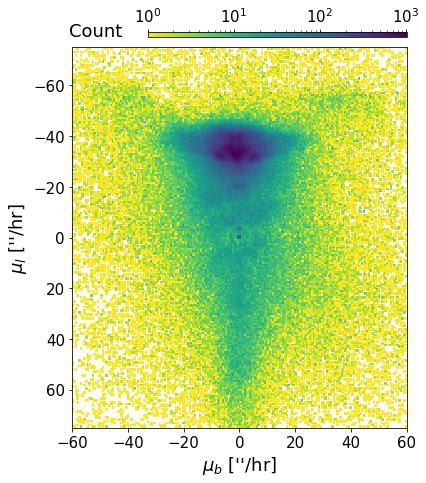

In [17]:
lsize=18
tsize=15
pmtot=np.sqrt(((dat_t['vra'])**2)+dat_t['vdec']**2)
pmtoterr=np.sqrt((((dat_t['vra']**2)*(dat_t['vraerr']**2))+((dat_t['vdec']**2)*(dat_t['vdecerr']**2)))/((dat_t['vra']**2)+(dat_t['vdec']**2)))
sn=abs(pmtot/pmtoterr)>4

fig=plt.figure(figsize=(6,7))
cm = plt.cm.get_cmap('viridis_r')#afmhot
plt.hist2d(np.append(np.append(dat_m['veb']*3600/24,dat_t['veb'][sn][:,0]),dat_mc['veb']),np.append(np.append(dat_m['vel']*3600/24,dat_t['vel'][sn][:,0]),dat_mc['vel']),bins=200,range=[[-60, 60],[-75, 75]],cmap=cm,norm=colors.LogNorm(),cmin=1) #800
plt.ylim(75,-75)
plt.xlim(-60,60)
plt.ylabel("$\mu_{l}$ [''/hr]",size=lsize,color="k") #l = lat
plt.xlabel("$\mu_{b}$ [''/hr]",size=lsize,color="k") #b = lon
plt.xticks(fontsize=tsize)
plt.yticks(fontsize=tsize)
plt.tick_params(axis='both', colors='k')
cbaxes = fig.add_axes([0.3, .9, 0.6, 0.01]) #[left,bottom,width,height]
bar=plt.colorbar(cax = cbaxes,orientation='horizontal')
cbaxes.xaxis.set_ticks_position('top')
bar.set_label('Count',fontsize=lsize,labelpad=-15,x=-0.2,color="k",rotation=0)
plt.setp(plt.getp(bar.ax.axes, 'xticklabels'), color="k",fontsize=tsize,rotation=0)
plt.show()

## Color & Magnitude

In [74]:
# prepare data for CCD & CMD:
gs=dat_m['g']!=99.99
rrs=dat_m[gs]['r']!=99.99
iiis=dat_m[gs][rrs]['i']!=99.99
dat_cmd=dat_m[gs][rrs]
dat_ccd=dat_m[gs][rrs][iiis]

# prepare data for Norm. Magnitude Histogram:
us=dat_m['u']!=99.99
mag_u=dat_m[us]['u']

gs=dat_m['g']!=99.99
mag_g=dat_m[gs]['g']

rs=dat_m['r']!=99.99
mag_r=dat_m[rs]['r']

iis=dat_m['i']!=99.99
mag_i=dat_m[iis]['i']

zs=dat_m['z']!=99.99
mag_z=dat_m[zs]['z']

ys=dat_m['y']!=99.99
mag_y=dat_m[ys]['y']

vrs=dat_m['vr']!=99.99
mag_vr=dat_m[vrs]['vr']

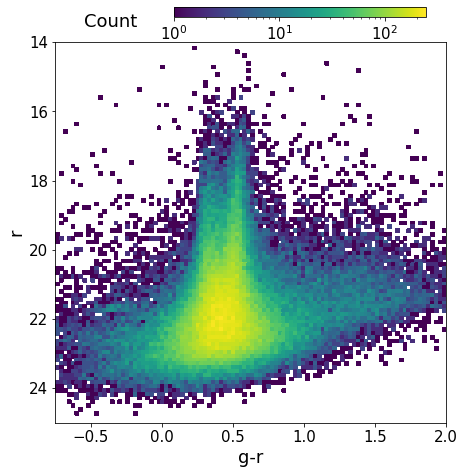

In [73]:
lsize=15 #marker label size
tsize=18 #axes label size
cm = plt.cm.get_cmap('viridis') #colormap

plt.figure(figsize=(7,7))
plt_cmd=plt.hist2d((datarg['g']-datarg['r']),abs(datarg['r']),bins=100,range=[[-0.75,2.0],[14,25]],cmap=cm,norm=colors.LogNorm())
cbaxes = [0.36, .93, 0.5, 0.02] #placement for the colorbar
cbar(plt_cmd[3],title="Count",caxx=cbaxes,loc="top",ori="horizontal",titsize=tsize,marksize=lsize,titcol="k",lpad=-30,titrot=0,markrot=0,ticklab="xticklabels",bpad=-10,xx=-0.25)
plt.xlabel("g-r",fontsize=tsize)
plt.ylabel("r",fontsize=tsize)
plt.tick_params(axis='both', which='major', labelsize=lsize, labelrotation=0)
plt.ylim(25,14)
plt.show()

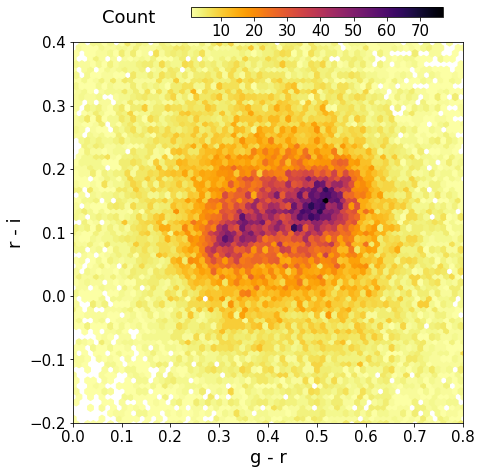

In [72]:
lsize=15
tsize=18
cm = plt.cm.get_cmap('inferno_r')

plt.figure(figsize=(7,7))
plt_ccd=plt.hexbin((dat_ccd['g']-dat_ccd['r']),(dat_ccd['r']-dat_ccd['i']),gridsize=1500,cmap=cm,mincnt=1)
cbaxes = [0.36, .93, 0.5, 0.02] #placement for the colorbar
cbar(plt_ccd,title="Count",caxx=cbaxes,loc="top",ori="horizontal",titsize=tsize,marksize=lsize,titcol="k",lpad=-30,titrot=0,markrot=0,ticklab="xticklabels",bpad=-10,xx=-0.25)
plt.xlabel("g - r",fontsize=tsize,color="k")
plt.ylabel("r - i",fontsize=tsize,color="k")
plt.tick_params(axis='both',which='major',labelsize=lsize,labelrotation=0,colors="k")
plt.xlim(0,0.8)
plt.ylim(-0.2,0.4)
plt.show()

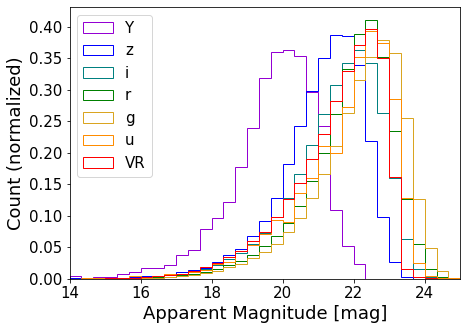

In [79]:
lsize=15
tsize=18
cols=["red","darkorange","goldenrod","green","teal","blue","darkviolet"] #colors for filter histogram lines
labs=["VR","u","g","r","i","z","Y"] #labels for filter histogram legend

plt.figure(figsize=(7,5))
plt.hist([mag_vr,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y],histtype="step",bins=33,color=cols,label=labs,range=(14,25),alpha=1,density=True) #histtype="barstacked"
plt.legend(prop={'size': lsize},loc="upper left") 
plt.ylabel("Count (normalized)",fontsize=tsize)
plt.xlabel("Apparent Magnitude [mag]",fontsize=tsize)
plt.tick_params(axis="both",which="major",labelsize=lsize)
plt.xlim(14,25)
plt.show()

## All-sky density plots
using healpy's mollview visualisation function https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.mollview.html  

In [194]:
%%time
# to get an hpix map of tracklet detection location density:
eq_ra=np.append(dat_m['ra'],dat_mc['ra']) #equatorial tracklet coordinates 
eq_dec=np.append(dat_m['dec'],dat_mc['dec'])
eq_coords=SkyCoord(ra=eq_ra*u.degree,dec=eq_dec*u.degree, frame="icrs",unit="degree")
ec_coords=eq_coords.transform_to('geocentrictrueecliptic') #ecliptic tracklet coordinates
hpx_tracklets,id_tracklets = cat2hpx(ec_coords.lon.value,ec_coords.lat.value,nside=128) #create the hpix map
arr_tracklets=hpx_tracklets.astype('float') 
arr_tracklets[arr_tracklets==0]=np.nan

# to get an hpix map of all HEAPLix searched by CANFind:
indices1=np.array(hp_dat['PIX']) #all included healpix 
pix_coords=hp.pix2ang(128,indices1,lonlat=True) #equatorial HEALPix coordinates
pix_eq=SkyCoord(ra=pix_coords[0]*u.degree,dec=pix_coords[1]*u.degree, frame="icrs",unit="degree")
pix_ec=pix_eq.transform_to('geocentrictrueecliptic') #ecliptic HEALPix coordinates
hpx_pix,id_pix = cat2hpx(pix_ec.lon.value,pix_ec.lat.value,nside=128) #create the hpix map
arr_pix=hpx_pix.astype('float')
arr_pix[arr_pix==2]=1

# to get an hpix map of tracklet detection in opposition-centric coordinates:
tracklet_mjd=np.append(dat_m['mjd'],dat_mc['mjd']) #tracklet observation times in Modified Julien Date (mjd)
tracklet_t=Time(tracklet_mjd,format="mjd")
sun_coords=get_sun(tracklet_t) #GCRS sun coordinates at times of tracklet observation
sun_eq = SkyCoord(ra=sun_coords.ra, dec=sun_coords.dec, frame='gcrs',unit='degree')
sun_ec=sun_eq.transform_to('geocentrictrueecliptic') #ecliptic sun coordinates at times of tracklet observation
hpx_opp,id_opp = cat2hpx((180-(ec_coords.lon.value-sun_ec.lon.value)),ec_coords.lat.value,nside=128) #create the hpix map 
arr_opp=hpx_opp.astype('float')
arr_opp[arr_opp==0]=np.nan

# to get an hpix map of exposure density for all HEALPix searched:
hp_exp_density=[]
#for ln in hpfile:
#    hp_exp_density+=list(np.repeat(ln['PIX'],int(ln['NEXPOSURES'])))
for ln in hp_dat:
    for i in range(0,int(ln['NEXPOSURES'])):
        hp_exp_density.append(ln['PIX'])
hp_exp_density=np.array(hp_exp_density)
hpex_c=hp.pix2ang(128,hp_exp_density,lonlat=True) #hp coords
hpex_eq=SkyCoord(ra=hpex_c[0]*u.degree,dec=hpex_c[1]*u.degree, frame="icrs",unit="degree")
hpex_ec=hpex_eq.transform_to('geocentrictrueecliptic')
hpx_hpex,id_hpex = cat2hpx(hpex_ec.lon.value,hpex_ec.lat.value,nside=128)
arr_hpex=hpx_hpex.astype('float')#the healpix that had enough exposures
arr_hpex[arr_hpex==0]=np.nan

CPU times: user 1min 23s, sys: 1.45 s, total: 1min 25s
Wall time: 1min 25s


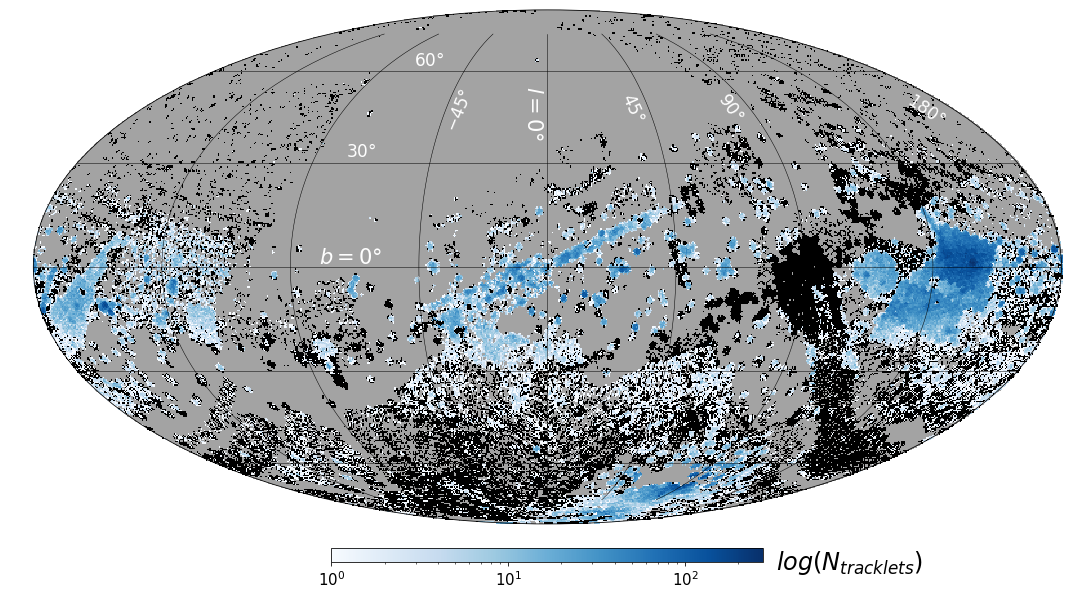

In [178]:
lcol="white"
lsize=17

figg=plt.figure(num=1,figsize=(15,10))
hp.mollview(arr_pix,title="",fig=1,cmap=plt.cm.get_cmap('nipy_spectral_r'),cbar=False)
hp.mollview(arr_tracklets,unit=" ",title="",badcolor=[0,0,0,0.2],fig=1,cmap=plt.cm.get_cmap('Reds'),cbar=False)
hp.mollview(arr_tracklets,unit=" ",title="",badcolor=[0,0,0,0],fig=1,cmap=plt.cm.get_cmap('Blues'),cbar=False,norm=colors.LogNorm())

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal")
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label("$log(N_{tracklets})$",size=24,labelpad=-40,rotation=0,x=1.2)
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)


ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.xaxis.set_major_formatter(ThetaFormatterShiftPi())
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(150),np.deg2rad(42),"$180\degree$",rotation=-35,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-43),np.deg2rad(40),"$-45\degree$",rotation=68,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-10),np.deg2rad(38),"$l=0\degree$",rotation=-90,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(30),np.deg2rad(43),"$45\degree$",rotation=-66,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(71),np.deg2rad(43),"$90\degree$",rotation=-56,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-75),np.deg2rad(62),"$60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-78),np.deg2rad(32),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-80),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.show()

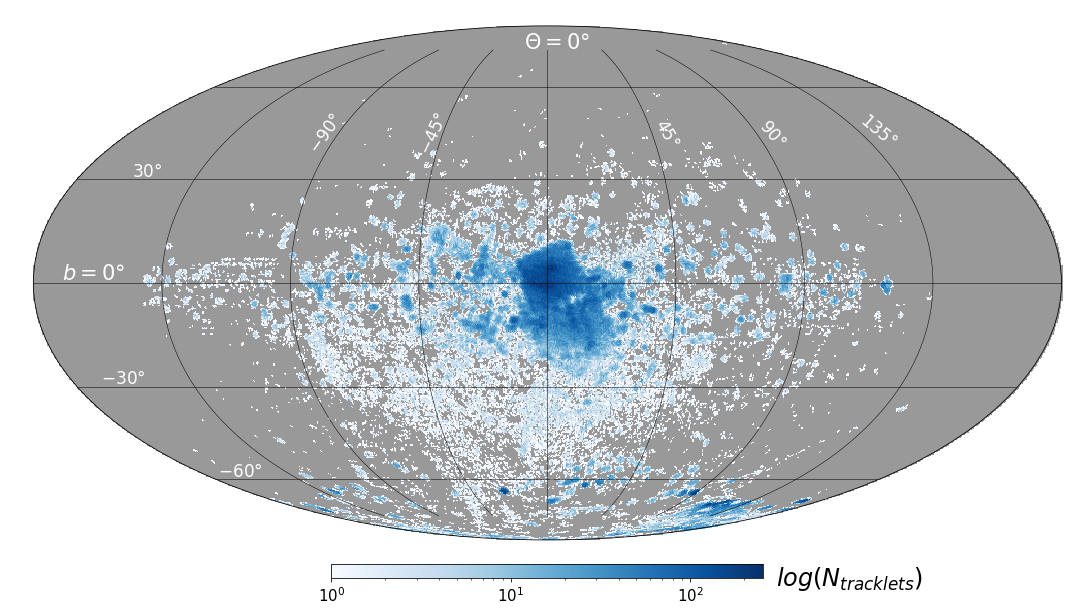

In [177]:
lcol="white"
lsize=17

figg=plt.figure(num=1,figsize=(15,10))
hp.mollview(arr_opp,unit=" ",title=" ",cmap=plt.cm.get_cmap('Blues'),badcolor=[0,0,0,0.4],cbar=False,fig=1)
hp.mollview(arr_opp,unit=" ",title=" ",cmap=plt.cm.get_cmap('Blues'),badcolor=[0,0,0,0],cbar=False,fig=1,xsize=1000,norm=colors.LogNorm())

fig = plt.gcf()
axc = plt.gca()
image = axc.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal")
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label("$log(N_{tracklets})$",size=24,labelpad=-40,rotation=0,x=1.2)
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)

ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(-98),np.deg2rad(38),"$-90\degree$",rotation=55,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-53),np.deg2rad(38),"$-45\degree$",rotation=65,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-20),np.deg2rad(76),"$\Theta=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(43),np.deg2rad(40),"$45\degree$",rotation=-60,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(86),np.deg2rad(40),"$90\degree$",rotation=-50,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(128),np.deg2rad(40),"$135\degree$",rotation=-40,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-160),np.deg2rad(31),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-170),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(-170),np.deg2rad(-29),"$-30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-175),np.deg2rad(-59),"$-60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.show()

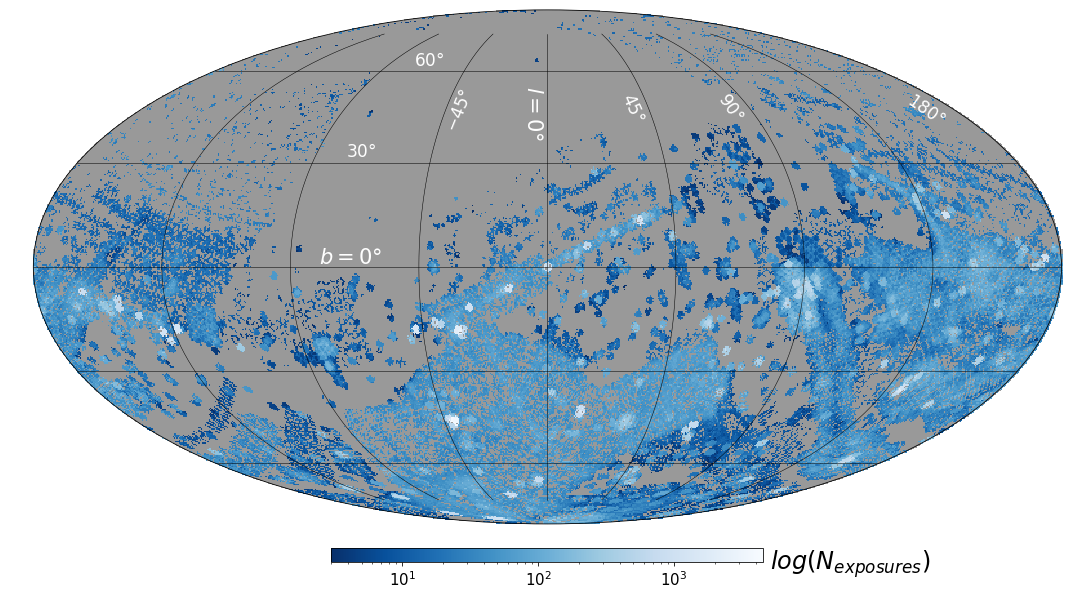

In [215]:
figg=plt.figure(num=1,figsize=(15,10))
hp.mollview(arr_hpex,unit=" ",title="",cmap=plt.cm.get_cmap('Blues_r'),badcolor=[0,0,0,0.4],cbar=False,fig=1,bgcolor=[0,0,0,0])
hp.mollview(arr_hpex,unit=" ",title="",cmap=plt.cm.get_cmap('Blues_r'),badcolor=[0,0,0,0],cbar=False,fig=1,bgcolor=[0,0,0,0],norm=colors.LogNorm())


fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal")
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label("$log(N_{exposures})$",size=24,labelpad=-40,rotation=0,x=1.2)
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)


ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.xaxis.set_major_formatter(ThetaFormatterShiftPi())
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(150),np.deg2rad(42),"$180\degree$",rotation=-35,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-43),np.deg2rad(40),"$-45\degree$",rotation=68,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-10),np.deg2rad(38),"$l=0\degree$",rotation=-90,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(30),np.deg2rad(43),"$45\degree$",rotation=-66,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(71),np.deg2rad(43),"$90\degree$",rotation=-56,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-75),np.deg2rad(62),"$60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-78),np.deg2rad(32),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-80),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.show()

In [210]:
hp_exp_density=[]
#for ln in hpfile:
#    hp_exp_density+=list(np.repeat(ln['PIX'],int(ln['NEXPOSURES'])))
for ln in hp_dat:
    for i in range(0,int(ln['NEXPOSURES'])):
        hp_exp_density.append(ln['PIX'])
hp_exp_density=np.array(hp_exp_density)
hpex_c=hp.pix2ang(128,hp_exp_density,lonlat=True) #hp coords
hpex_eq=SkyCoord(ra=hpex_c[0]*u.degree,dec=hpex_c[1]*u.degree, frame="icrs",unit="degree")
hpex_ec=hpex_eq.transform_to('geocentrictrueecliptic')
hpx_hpex,id_hpex = cat2hpx(hpex_ec.lon.value,hpex_ec.lat.value,nside=128)
arr_hpex=hpx_hpex.astype('float')#the healpix that had enough exposures
arr_hpex[arr_hpex==0]=np.nan

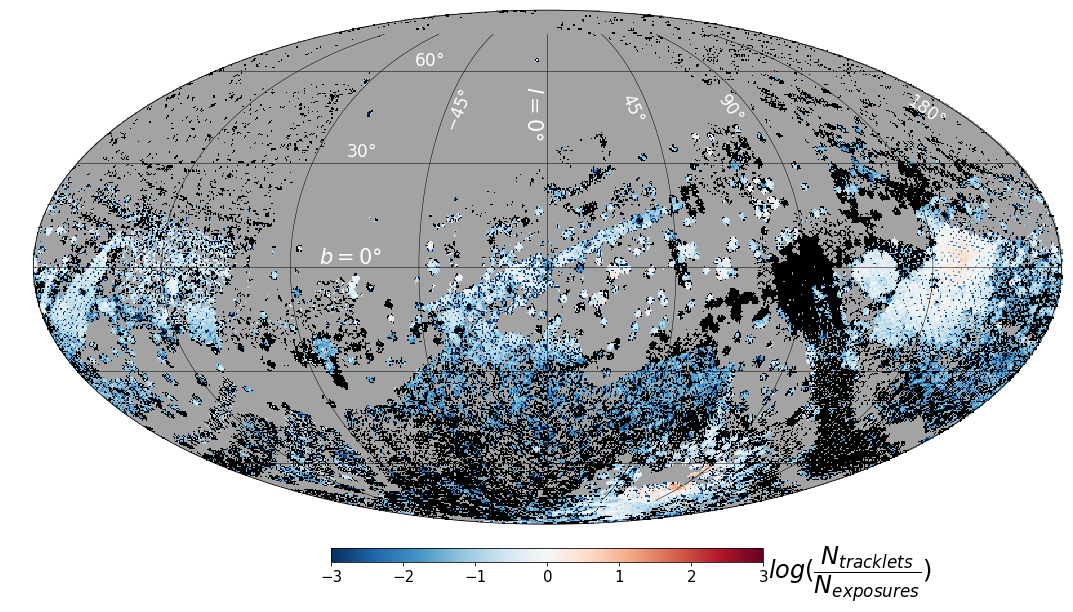

In [228]:
figg=plt.figure(num=1,figsize=(15,10))
hp.mollview(arr_pix,title="",fig=1,cmap=plt.cm.get_cmap('nipy_spectral_r'),cbar=False,bgcolor=[0,0,0,0])
hp.mollview(arr_tracklets,unit=" ",title="",cmap=plt.cm.get_cmap('Blues_r'),badcolor=[0,0,0,0.2],cbar=False,fig=1,bgcolor=[0,0,0,0])
#hp.mollview(2.5*np.log10(arr),unit=" ",title="Geocentric Ecliptic Coordinates",badcolor=[0,0,0,0],fig=1,cmap=plt.cm.get_cmap('Blues'),cbar=False,bgcolor=[0,0,0,0])
hp.mollview(np.log10(arr_tracklets/arr_hpex),unit=" ",title="",cmap=plt.cm.get_cmap('RdBu_r'),badcolor=[0,0,0,0],cbar=False,fig=1,bgcolor=[0,0,0,0])


fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbaxes = fig.add_axes([0.3,0.09, 0.4, 0.02]) 
cmp = fig.colorbar(image, cax=cbaxes,orientation="horizontal")
cbaxes.xaxis.set_ticks_position('bottom')
cmp.set_label("$log(\dfrac{N_{tracklets}}{N_{exposures}})$",size=24,labelpad=-40,rotation=0,x=1.2)
plt.setp(plt.getp(cmp.ax.axes, 'xticklabels'), color="k",fontsize=15,rotation=0)
image.set_clim(-3,3)

ax=figg.add_subplot(111,projection='mollweide',facecolor=[0,0,0,0])
spacing = 0.024
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)
ax.set_longitude_grid(45)
ax.xaxis.set_major_formatter(ThetaFormatterShiftPi())
ax.set_latitude_grid(30)
ax.grid(True,which="major",color=[0,0,0,0.1],linewidth=.5)
ax.tick_params(axis="y",which="major",labelcolor=[0,0,0,0],labelsize=16,direction="in",pad=20)
ax.tick_params(axis="x",which="major",labelcolor=[0,0,0,0])
plt.text(np.deg2rad(150),np.deg2rad(42),"$180\degree$",rotation=-35,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-43),np.deg2rad(40),"$-45\degree$",rotation=68,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-10),np.deg2rad(38),"$l=0\degree$",rotation=-90,fontsize=lsize+4,color=lcol)
plt.text(np.deg2rad(30),np.deg2rad(43),"$45\degree$",rotation=-66,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(71),np.deg2rad(43),"$90\degree$",rotation=-56,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-75),np.deg2rad(62),"$60\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-78),np.deg2rad(32),"$30\degree$",rotation=0,fontsize=lsize,color=lcol)
plt.text(np.deg2rad(-80),np.deg2rad(1),"$b=0\degree$",rotation=0,fontsize=lsize+4,color=lcol)
plt.show()